# Benchmarking MI estimators by resampling MNIST

Here, we resample paired images from MNIST to construct "real" high dimensional variables with known or well approximated MI.




In [1]:
%%capture

import time
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".10"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

from lmi import lmi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torch
from tqdm.notebook import tqdm

from scipy.stats import kendalltau

from keras.datasets import mnist

from bmi.estimators import MINEEstimator as MINE
from bmi.estimators import InfoNCEEstimator as InfoNCE

torch.manual_seed(2121)
np.random.seed(2121)

/home/gokul/.local/lib/python3.10/site-packages/jaxtyping/__init__.py:210: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(


Labels: (0, 0)


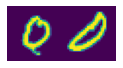

Labels: (1, 1)


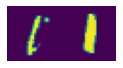

Sanity check (percent identical labels, should be ~0.75): 0.752400


In [2]:
(x_train, y_train), _ = mnist.load_data()

X_data, Y_data = [], []
labels = []

for i in range(2):
    imgs = [x[0] for x in x_train[np.argwhere(y_train == i)]]
    X_data += imgs[:2500]
    Y_data += imgs[2500:5000]
    labels += [i]*2500

X_data = np.array([x.flatten() for x in X_data])
Y_data = np.array([x.flatten() for x in Y_data])
labels = np.array(labels)

assert len(X_data) == len(Y_data)

def generate_dataset(percent_shuffle, N_samples=5*10**3):
    """
    shuffle pairs in a subset of the data
    """
    
    inds = np.arange(len(labels))
    np.random.shuffle(inds)
    
    Xs = X_data[inds[:N_samples]].copy()
    Ys = Y_data[inds[:N_samples]].copy()
    Lx = labels[inds[:N_samples]].copy()
    Ly = labels[inds[:N_samples]].copy()
    
    rows_to_shuffle = int(percent_shuffle*len(Xs))
    
    # get identical shuffles
    # thanks to https://stackoverflow.com/questions/4601373/
    # better-way-to-shuffle-two-numpy-arrays-in-unison
    rng_state = np.random.get_state()
    np.random.shuffle(Xs[:rows_to_shuffle])
    np.random.set_state(rng_state)
    np.random.shuffle(Lx[:rows_to_shuffle])
    
    return Xs, Ys, Lx, Ly

rcParams["figure.figsize"] = (2,1)

Xs, Ys, Lx, Ly = generate_dataset(0.5)
for k in np.random.choice(np.arange(len(Xs)), 2):
    print("Labels: (%d, %d)"%(Lx[k], Ly[k]))
    plt.imshow(np.hstack((Xs[k].reshape(28, 28), Ys[k].reshape(28,28))))
    plt.axis('off')
    plt.show()
    
print("Sanity check (percent identical labels, should be ~0.75): %f"
      %(sum(Lx == Ly)/len(Lx)))

In [3]:
np.seterr(divide='ignore', invalid='ignore')

smi_d = {
    "Estimate" : [],
    "Label MI" : [],
    "Dimension" : [],
    "Measure" : [],
    "Time" : [],
    }

for ps in tqdm(np.linspace(0, 1, 200)):
    
    N_dims = 784
    
    Xs, Ys, Lx, Ly = generate_dataset(ps**2)
    
    Xs = np.nan_to_num((Xs - Xs.mean(axis=0)) / Xs.std(axis=0))
    Ys = np.nan_to_num((Ys - Ys.mean(axis=0)) / Ys.std(axis=0))
    
    DMI = lmi.ksg.midd(Lx, Ly)
    t0 = time.time()
    mine = MINE(verbose=False)
    mine_mi = mine.estimate(Xs, Ys) # in nats
    t1 = time.time()
    
    smi_d["Estimate"].append(mine_mi/np.log(2))
    smi_d["Label MI"].append(DMI)
    smi_d["Dimension"].append(N_dims)
    smi_d["Measure"].append("MINE")
    smi_d["Time"].append(t1-t0)

    t0 = time.time()
    infonce = InfoNCE(verbose=False)
    infonce_mi = infonce.estimate(Xs, Ys)
    t1 = time.time()
    
    smi_d["Estimate"].append(infonce_mi/np.log(2))
    smi_d["Label MI"].append(DMI)
    smi_d["Dimension"].append(N_dims)
    smi_d["Measure"].append("InfoNCE")
    smi_d["Time"].append(t1-t0)

    t0 = time.time()
    smi_d["Estimate"].append(np.mean(lmi.ksg.mi(Xs, Ys)))
    t1 = time.time()
    smi_d["Label MI"].append(DMI)
    smi_d["Dimension"].append(N_dims)
    smi_d["Measure"].append("KSG")
    smi_d["Time"].append(t1-t0)
    
    t0 = time.time()
    smi_d["Estimate"].append(np.nanmean(lmi.lmi(Xs, Ys)[0]))
    t1 = time.time()
    smi_d["Label MI"].append(DMI)
    smi_d["Dimension"].append(N_dims)
    smi_d["Measure"].append("LMI-Cross")
    smi_d["Time"].append(t1-t0)
    
    t0 = time.time()
    smi_d["Estimate"].append(np.nanmean(lmi.lmi(Xs, Ys,
                                              regularizer='models.AEInfoNCE')[0]))
    t1 = time.time()
    smi_d["Label MI"].append(DMI)
    smi_d["Dimension"].append(N_dims)
    smi_d["Measure"].append("LMI-InfoNCE")
    smi_d["Time"].append(t1-t0)
    
    t0 = time.time()
    smi_d["Estimate"].append(np.nanmean(lmi.lmi(Xs, Ys,
                                               regularizer='models.AEMINE')[0]))
    t1 = time.time()
    smi_d["Label MI"].append(DMI)
    smi_d["Dimension"].append(N_dims)
    smi_d["Measure"].append("LMI-MINE")
    smi_d["Time"].append(t1-t0)


  0%|          | 0/200 [00:00<?, ?it/s]

In [4]:
smi_df = pd.DataFrame(smi_d)

<AxesSubplot:xlabel='Label MI', ylabel='Estimate'>

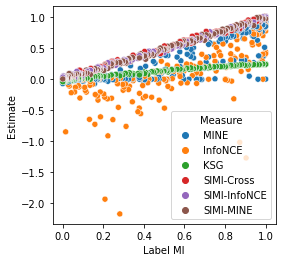

In [5]:
rcParams['figure.figsize'] = (4,4)
sns.scatterplot(smi_df,
                y='Estimate',
                x='Label MI',
                hue='Measure')

In [6]:
smi_df.to_csv("../results/B_MNIST.csv")